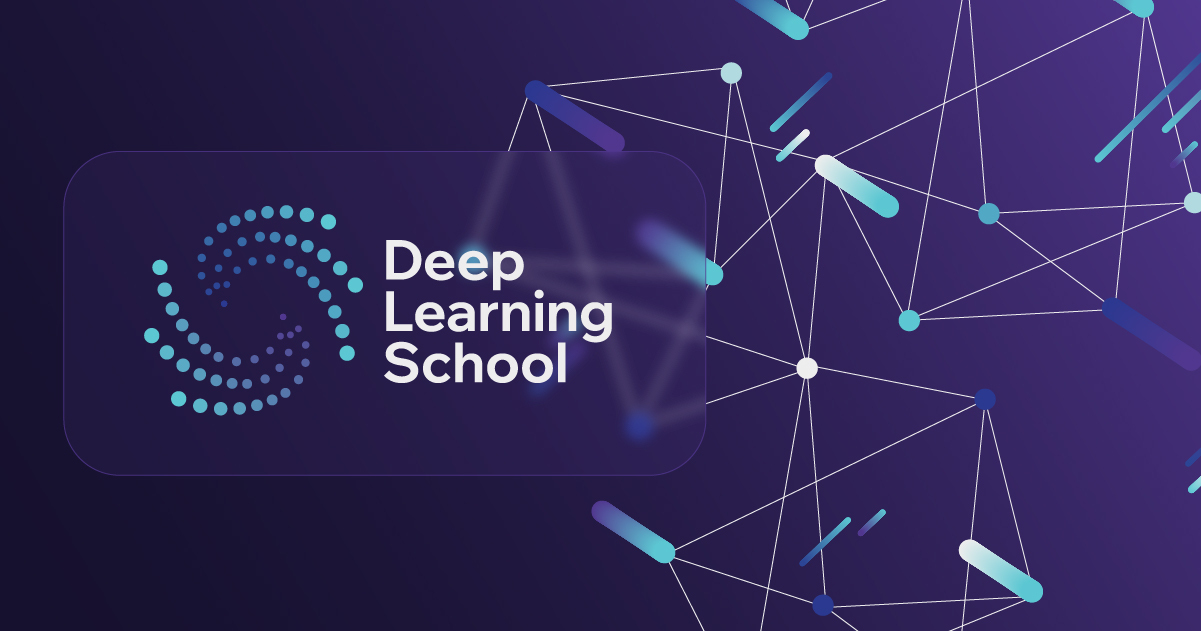

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h1 style="text-align: center;"><b>Семинар. Детекция объектов. Часть 1.</b></h1>


# Если запускаете из коллаба
# pip install torchmetrics

In [2]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 86.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 72.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 64.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [3]:
import math
from functools import partial
from collections import Counter, defaultdict

import io
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import timm
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from PIL import Image
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.ops import nms, box_iou
from torchvision.models.detection.anchor_utils import AnchorGenerator

from torchmetrics.detection import MeanAveragePrecision

# Object Detector from scratch

Давайте напишем свой первый детектор с нуля.

Сегодня нам предстоит самоятоятельно реализовать следующие вещи:

1. Поработать с датасетом,
    * Загрузить данные,
    * Посмотреть примеры,
    * Провести небольшой анализ данных,
2. Написать основные методы работы с данными,
    * Dataset, Dataloader
3. Реализовать детектор по частям,
    * Backbone, Neck, Head и общий класс Detector
4. Добавить алгоритм обучения модели,
    * label assignment,
    * Loss computation,
    * Validation,
6. Оценить качество итогового детектора.
   * Используя COCO API посчитать mAP
  
И, для начала, поговорим о данных с которыми нам предстоит работать

### Working with dataset

In [4]:
# Определяем константы для цвета и названий классов
# Класс - цвет
class_to_color = {
    1: (89, 161, 197),
    2: (204, 79, 135),
    3: (125, 216, 93),
    4: (175, 203, 33),
}

# Класс - имя
class_to_name = {
    1 : "enemy",
    2 : "enemy-head",
    3 : "friendly",
    4 : "friendly-head"
}

# Путь скачивания
splits = {'train': 'data/train-00000-of-00001-0d6632d599c29801.parquet',
          'validation': 'data/validation-00000-of-00001-c6b77a557eeedd52.parquet',
          'test': 'data/test-00000-of-00001-866d29d8989ea915.parquet'}
df_train = pd.read_parquet("hf://datasets/Francesco/halo-infinite-angel-videogame/" + splits["train"])
df_test = pd.read_parquet("hf://datasets/Francesco/halo-infinite-angel-videogame/" + splits["test"])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Выведем пример данных

In [5]:
df_train.head()

,image_id,image,width,height,objects
0,311,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,640,640,"{'id': [573, 574], 'area': [1748, 15756], 'bbo..."
1,67,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,640,640,"{'id': [137, 138], 'area': [14136, 88392], 'bb..."
2,161,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,640,640,"{'id': [301, 302], 'area': [3016, 33768], 'bbo..."
3,210,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,640,640,"{'id': [379, 380], 'area': [832, 9248], 'bbox'..."
4,142,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,640,640,"{'id': [272, 273], 'area': [1520, 16704], 'bbo..."


In [6]:
# Вспомогательные функции для отрисовки данных
def add_bbox(image, box, label='', color=(128, 128, 128), txt_color=(0, 0, 0)):
    lw = max(round(sum(image.shape) / 2 * 0.003), 2)
    p1, p2 = (int(box[0]), int(box[1])), (int(box[0]) + int(box[2]), int(box[1]) + int(box[3]))
    cv2.rectangle(image, p1, p2, color, thickness=lw, lineType=cv2.LINE_AA)
    if label:
        tf = max(lw - 1, 1)
        w, h = cv2.getTextSize(label, 0, fontScale=lw / 3, thickness=tf)[0]
        outside = p1[1] - h >= 3
        p2 = p1[0] + w, p1[1] - h - 3 if outside else p1[1] + h + 3
        cv2.rectangle(image, p1, p2, color, -1, cv2.LINE_AA)
        cv2.putText(image,
                    label, (p1[0], p1[1] - 2 if outside else p1[1] + h + 2),
                    0,
                    lw / 3,
                    txt_color,
                    thickness=tf,
                    lineType=cv2.LINE_AA)
    return image

def plot_examples(df, indices=None, num_examples=6, row_figsize=(12, 3)):
    if indices is None:
        indices = np.random.choice(len(df), size=num_examples, replace=False)
    else:
        num_examples = len(indices)
    ncols = min(num_examples, 3)
    nrows = math.ceil(num_examples / 3)
    _, axes = plt.subplots(nrows, ncols, figsize=(row_figsize[0], row_figsize[1] * nrows), tight_layout=True)
    axes = axes.reshape(-1)
    for ix, ax in zip(indices, axes):
        row = df.iloc[ix]
        image = Image.open(io.BytesIO(row['image']['bytes']))
        bboxes = row["objects"]['bbox']
        classes = row["objects"]['category']
        img = np.array(image)
        for bbox, label in zip(bboxes, classes):
            color = class_to_color[label]
            class_name = class_to_name[label]
            img = add_bbox(img, bbox, label=str(class_name), color=color)
        ax.imshow(img)
        ax.set_title(f"Image id: {row['image_id']}")
        ax.set_xticks([])
        ax.set_yticks([])

Нарисуем несколько примеров картинок из обучающей выборки

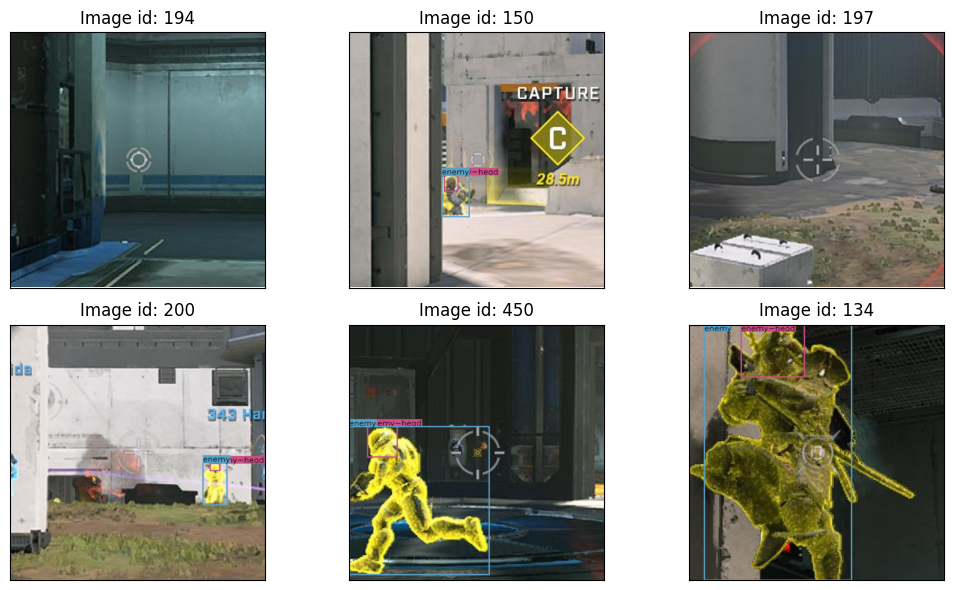

In [7]:
plot_examples(df_train)

Нарисуем несколько примеров картинок из тестовой выборки

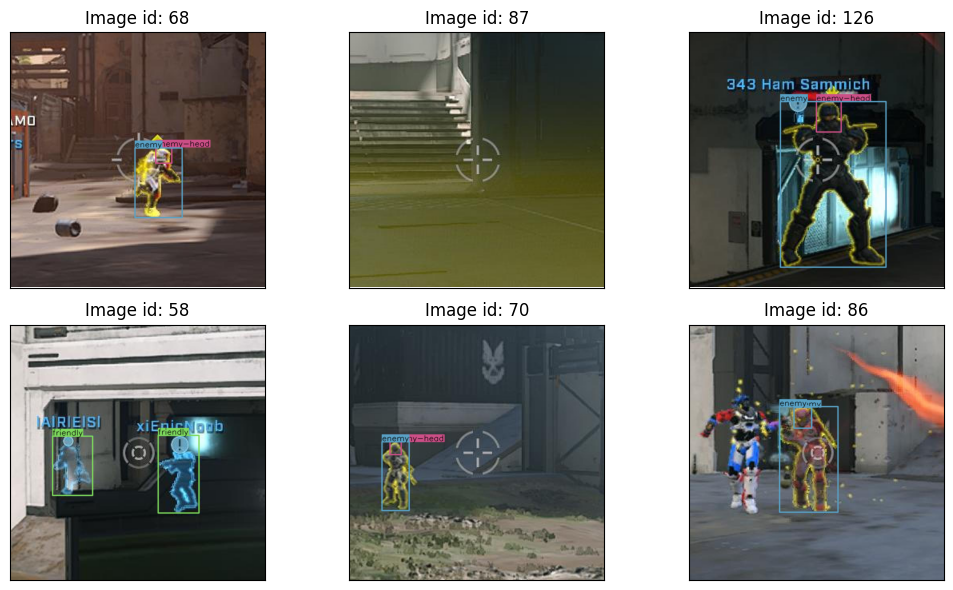

In [8]:
plot_examples(df_test)

Посчитаем количество данных в двух датасетах

In [9]:
print(f"Train length: {len(df_train)}\nTest length: {len(df_test)}")

Train length: 462
Test length: 136


Посмотрим на некоторые статистики по датасету

Min bboxes per image: 0
Max bboxes per image: 6
Mean bboxes per image: 1.84


Number of object per class:
enemy-head : 331
enemy : 387
friendly-head : 37
friendly : 93

Mean bbox size per class:
enemy : [117.48837 205.58656]
enemy-head : [46.95468  49.123867]
friendly : [113.91398 213.46237]
friendly-head : [61.45946 57.62162]





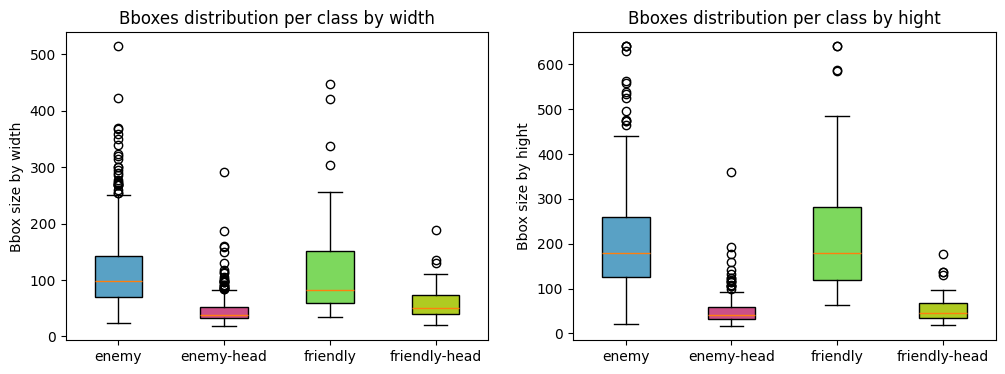

In [10]:
def part_info(df):
    """ Считаем статистики по датасету и рисуем распределение размеров ббоксов по классам. """
    df = pd.json_normalize(df['objects'])[["bbox", "category"]]
    obj_per_img = df['bbox'].apply(lambda obj: len(obj))
    print(f"Min bboxes per image: {obj_per_img.min()}")
    print(f"Max bboxes per image: {obj_per_img.max()}")
    print(f"Mean bboxes per image: {obj_per_img.mean():.3}")

    all_categories = df['category'].apply(lambda obj: obj).tolist()
    counter = Counter(np.concatenate(all_categories))
    msg = [f"{class_to_name[key]} : {value}" for key, value in counter.items()]
    print("\n\nNumber of object per class:\n" + "\n".join(msg))

    bboxes = defaultdict(list)
    for _, row in df.iterrows():
        for bb, cls in zip(row['bbox'], row['category']):
            bboxes[cls].append(list(bb[2:]))
    bboxes = dict(sorted(bboxes.items()))
    print("\nMean bbox size per class:")
    for cls, boxes_list in bboxes.items():
        print(f"{class_to_name[cls]} : {np.mean(boxes_list, axis=0)}")

    print("\n\n")
    _, axes = plt.subplots(1, 2, figsize=(12, 4))
    x_boxes = [np.array(val)[:, 0] for val in bboxes.values()]
    y_boxes = [np.array(val)[:, 1] for val in bboxes.values()]
    labels = [class_to_name[cls] for cls in class_to_name.keys()]
    colors = [class_to_color[cls] for cls in class_to_color.keys()]
    for ax, box, direction in zip(axes, [x_boxes, y_boxes], ["width", "hight"]):
        bplot = ax.boxplot(box, patch_artist=True, tick_labels=labels)
        for patch, color in zip(bplot["boxes"], colors):
            patch.set_facecolor(np.array(color) / 255)
        ax.set_ylabel(f"Bbox size by {direction}")
        ax.set_title(f"Bboxes distribution per class by {direction}")

box_sizes = part_info(df_train)

Min bboxes per image: 0
Max bboxes per image: 6
Mean bboxes per image: 1.9


Number of object per class:
enemy-head : 104
enemy : 113
friendly-head : 12
friendly : 30

Mean bbox size per class:
enemy : [114.0531 207.9469]
enemy-head : [44.057693 46.384617]
friendly : [ 99.8     215.26666]
friendly-head : [44.       39.166668]





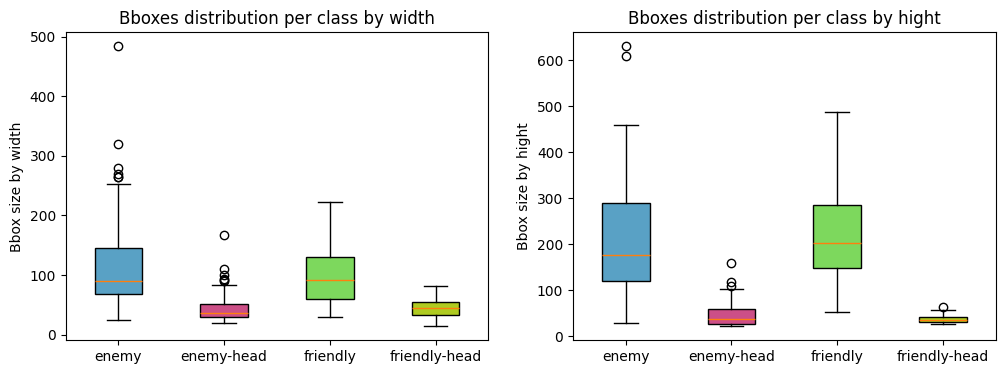

In [11]:
box_sizes = part_info(df_test)

Справка про boxplot из [matplotlib](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.boxplot.html):


![image.png](attachment:5e15ffae-9959-4dc3-a4a8-5d45d5efe7f9.png)

Отлично, на данные посмотрели, теперь давайте напишем Dataset, с помощью которого будем загружать данные.

In [14]:
class HaloDataset(Dataset):
    # Принимаем на вход dataframe(изображения + разметка), transform
    def __init__(self, dataframe, transform=None):
        # Извлекаем bbox, category. Normalized превращает в плоский dataframe
        df_objects = pd.json_normalize(dataframe['objects'])[["bbox", "category"]]
        # Извлекаем байтовое представление изображения
        df_images = pd.json_normalize(dataframe['image'])[["bytes"]]
        # Объединяются image_id, bbox, category и bytes в единый DataFrame.
        self.data = dataframe[["image_id"]].join(df_objects).join(df_images)
        # Сохраняется переданная трансформация для последующего применения.
        self.transform = transform

    def __len__(self):
        return len(self.data)

    #Возвращает пару (image, target) по индексу idx
    def __getitem__(self, idx):
        """Загружаем данные и разметку для объекта с индексом `idx`.

        labels: List[int] Набор классов для каждого ббокса,
        boxes: List[List[int]] Набор ббоксов в формате (x_min, y_min, w, h).
        """
        # Извлекаем объект
        row = self.data.iloc[idx]
        # Преобразует в PIL.Image
        image = Image.open(io.BytesIO(row["bytes"]))
        # Конвертируем в numpy
        image = np.array(image)

        target = {}
        target["image_id"] = row["image_id"]

        labels = [row["category"]] if isinstance(row["category"], int) else row['category']
        # Вычитаем единицу чтобы классы начинались с нуля
        labels = [label - 1 for label in labels]
        boxes = row['bbox'].tolist()

        if self.transform is not None:
            transformed = self.transform(image=image, bboxes=boxes, labels=labels)
            image, boxes, labels = transformed["image"], transformed["bboxes"], transformed["labels"]
        else:
            image = transforms.ToTensor()(image)

        target['boxes'] = torch.tensor(np.array(boxes), dtype=torch.float32)
        target['labels'] = torch.tensor(labels, dtype=torch.int64)
        return image, target

#Функция объединения батча
def collate_fn(batch):
    batch = tuple(zip(*batch))
    images = torch.stack(batch[0])
    return images, batch[1]

In [13]:
# Немного аугментаций
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

train_transform = A.Compose(
    [
        A.Normalize(mean=mean, std=std),
        # HorizontalFlip меняет и ббоксы!
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.2),
        ToTensorV2(),
    ],
    bbox_params=A.BboxParams(format='coco', label_fields=['labels'])
)

test_transform = A.Compose(
    [
        A.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ]
)

Создадим Dataset для наших данных

In [15]:
train_dataset = HaloDataset(df_train, transform=train_transform)
test_dataset = HaloDataset(df_test, transform=test_transform)

### On the Way to Object Detector

Вспомним как выглядит общая структура модели:

![Base detector schema full.png](attachment:1698d15c-c1e9-433c-90f0-0a1a4056e318.png)

Мы будем реализовывать самый простой вариант object detector'a, чем то похожий на первые YOLO модели с использованием якорей.

В качестве backbone можно использовать любую классификационную модель. Давайте выберем предобученную на ImageNet модель, и заморозим у неё все слои, чтобы нам было проще обучать модель.

TIP: Можно разморозить несколько последних слоев и обучать их тоже, качество может стать лучше.

In [17]:

class Backbone(nn.Module):
    # Backbone будет использовать предобученнную модель в каччестве извлекателя признаков
    # model name из библиотеки timm, feature maps последних трех слоев
    def __init__(self, model_name="efficientnet_b0", out_indices=(-1, -2, -3)):
        super().__init__()
        # Как раз создаем предобученнную модель с выходами из последних трех слоев
        self.backbone = timm.create_model(model_name, pretrained=True, features_only=True, out_indices=out_indices)
        # Выключаем градиенты у модели, чтобы упростить обучение
        for param in self.backbone.parameters():
            param.requires_grad = False

    #передаём входное изображение в backbone и возвращаем список признаков.
    def forward(self, x):
        return self.backbone(x)

Теперь напишем два простых класса для шеи и головы нашего детектора.

Для простоты будем реализовывать детектор с одним выходом, поэтому шея будет максимально простая.

In [18]:
# Модуль, который обрабатывает признаки из бэкбона перед детекцией
class SimplifiedFPN(nn.Module):
    """Очень простая шея: один слой conv + batch_norm + activation. """
    def __init__(self, in_channels, out_channels, use_activations=True):
        super().__init__()
        self.fpn_conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.activation = nn.ReLU() if use_activations else nn.Identity()
        self.bn = nn.BatchNorm2d(out_channels)
    # Мы не используем все уровни, как в полной FPN;
    # А берём только один самый глубокий (features[0]) и обрабатываем его.
    def forward(self, features):
        return self.activation(self.bn(self.fpn_conv(features[0])))

# Предсказание боксов и классов
class DetectionHead(nn.Module):

    # Общий сверточный слой, затем разделение на классификацию и регрессию
    """ Двухсоставная голова, схематично выглядит следующим образом:
                      -> conv (cls) [B, NUM_ANCHORS * NUM_CLASSES, W, H]
        neck -> conv
                      -> conv (reg) [B, NUM_ACNHORS * 5, W, H]
    где число 5 обозначает 4 смещения для итогового + confidence score.
    """
    def __init__(self, in_channels, num_anchors, num_classes):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)
        self.cls_head = nn.Conv2d(in_channels, num_anchors * num_classes, kernel_size=1)
        self.reg_head = nn.Conv2d(in_channels, num_anchors * 5, kernel_size=1)
        self.num_classes = num_classes

    def forward(self, x):
        x = F.relu(self.conv(x))
        cls_logits = self.cls_head(x)
        bbox_preds = self.reg_head(x)
        return cls_logits, bbox_preds

Прежде чем собирать все вместе, давайте определимся что именно предсказывает наша сеть.

Для примера, давайте предсказывать смещения, также как в YOLOv3:

![image.png](attachment:da9209ed-3acc-499c-8992-36e1c7e8c09e.png), где

* $c_x, c_y$ - растояние от верхнего левого угла до начала ячейки,
* $p_w, p_h$ - размеры якоря,
* $t_x, t_y, t_w, t_h$ - предсказания модели,
* $b_x, b_y, b_w, b_h$ - итоговые размеры ббокса в формате YOLO.
  * $b_x, b_y$ - координаты центра ббокса,
  * $b_w, b_h$ - ширина, высота ббокса.

Теперь можем собрать все вместе и также реализовать преобразования из смещений в ббоксы для всех предсказаний.

In [19]:
class Detector(nn.Module):
    """ Класс детектора, объединяющий все части вместе.

    Параметры
    ---------
    backbone_model_name : str
        Имя timm модели, которая будет исопльзоваться в качестве backbone
    neck_n_channels : int
        Итоговое количество каналов на выходе шеи
    num_classes : int
        Количество классов в датасете
    anchor_sizes : list, tuple
        Базовые размеры якорей. Используется методом `AnchorDetector` из
        `torchvision.models.detection.anchor_utils`для создания якорей.
    anchor_ratios : list, tuple
        Соотношения сторон якорей. Используется методом `AnchorDetector` из
        `torchvision.models.detection.anchor_utils`для создания якорей.
    input_size : tuple with length 2
        Размер входного изображения. Используется для расчета положения всех якорей.

    NOTE: На самом деле, AnchorDetector на вход ждет anchor_sizes и anchor_ratios как Tuple[Tuple[int]],
    это связано с возможностью создания разных якорей для разных выходов модели. Сейчас нам это не нужно,
    поэтому структура намеренно упрощена.
    """
    def __init__(self,
                 backbone_model_name="efficientnet_b0",
                 neck_n_channels=256,
                 num_classes=4,
                 anchor_sizes=(32, 64, 128),
                 anchor_ratios=(0.5, 1.0, 2.0),
                 input_size=(640, 640),
        ):
        super().__init__()
        self.num_classes = num_classes
        # Создаем backbone с одним выходом, только из последнего слоя
        # Если нужно сделать несколько выходов, меняй out_indices
        self.backbone = Backbone(backbone_model_name, out_indices=(-1, ))
        # Получаем количество фичемапов на выходном слое
        in_channels = self.backbone.backbone.feature_info.channels()[0]
        # Создаем шею, с учетом параметров, полученных выше
        self.neck = SimplifiedFPN(in_channels, out_channels=neck_n_channels)
        # Размерность выходов головы зависит от количество якорей, поэтому сначала считаем количество якорей в каждой
        # ячейке выходной фичемапы
        num_anchors = len(anchor_sizes) * len(anchor_ratios)
        self.head = DetectionHead(in_channels=neck_n_channels, num_anchors=num_anchors, num_classes=num_classes)

        # Генерируем якоря
        anchor_generator = AnchorGenerator(sizes=(anchor_sizes, ), aspect_ratios=(anchor_ratios, ))
        # Узнаем размер выходной фичемапы
        reduction = self.backbone.backbone.feature_info.reduction()[0]
        grid_sizes = [[input_size[0] // reduction, input_size[1] // reduction]]

        # Расчитываем координаты якорей в каждой точке выходной фичемапы.
        ###
        # Якоря хранятся в формате (x_min, y_min, x_max, y_max)!
        ###
        anchors = anchor_generator.grid_anchors(grid_sizes, strides=[[reduction, reduction]])
        anchors = torch.stack(anchors, dim=0)
        # Заранее считаем координаты якорей в формате (x_center, y_center, w, h)
        # Это пригодится для расчета лосса
        anchor_centers = (anchors[:, :, :2] + anchors[:, :, 2:]) / 2
        anchor_sizes = (anchors[:, :, 2:] - anchors[:, :, :2])

        self.register_buffer("anchors", anchors)
        self.register_buffer("anchor_centers", anchor_centers)
        self.register_buffer("anchor_sizes", anchor_sizes)

    def forward(self, x):
        # Пропускаем картинку через всю сеть
        features = self.backbone(x)
        neck_features = self.neck(features)
        cls_logits, bbox_preds = self.head(neck_features)

        # Преобразуем сырые выходы модели в формат, в котором будет удобно считать лосс
        # cls_logits - [N, NUM_ANCHORS * NUM_CLASSES, W, H]
        # bbox_preds - [N, NUM_ANCHORS * 5, W, H]
        N = x.shape[0]
        cls_logits = cls_logits.permute(0, 2, 3, 1).contiguous()
        cls_logits = cls_logits.view(N, -1, self.head.num_classes) # [N, NUM_ANCHORS * W * H, NUM_CLASSES]
        #Из [B, C, H, W] → [B, H*W*A, num_classes].

        bbox_preds = bbox_preds.permute(0, 2, 3, 1).contiguous()
        bbox_preds = bbox_preds.view(N, -1, 5) # [N, NUM_ANCHORS * W * H, 5]
        bbox_offsets = bbox_preds[:, :, :4]
        confidence_logits = bbox_preds[:, :, 4]
        # Выделяем: bbox_offsets: смещения confidence: уверенность.

        if self.training:
            # В процессе тренировки возвращаем просто смещения и логиты
            return bbox_offsets, confidence_logits, cls_logits

        # Если мы делаем предсказание, сразу считаем итоговый ббокс и вероятности
        # Модель предсказывает ббоксы в формате (x_min, y_min, w, h)
        bboxes = self.decode_bboxes(bbox_offsets)
        confidence = torch.sigmoid(confidence_logits)
        cls_probs = torch.softmax(cls_logits, dim=-1)
        return bboxes, confidence, cls_probs


    def decode_bboxes(self, bbox_offsets):
      # Преобразуем к формату (x_min, y_min, w, h).
        """Используя предсказанные смещения, считаем предсказанные ббоксы по формулам из YOLOv3.

        Боксы возвращаются в формате (x_min, y_min, w, h).
        """
        tx = bbox_offsets[:, :, 0]
        ty = bbox_offsets[:, :, 1]
        tw = bbox_offsets[:, :, 2]
        th = bbox_offsets[:, :, 3]

        center_x = self.anchor_centers[:, :, 0] + torch.sigmoid(tx) * self.anchor_sizes[:, :, 0]
        center_y = self.anchor_centers[:, :, 1] + torch.sigmoid(ty) * self.anchor_sizes[:, :, 1]

        w = torch.exp(tw) * self.anchor_sizes[:, :, 0]
        h = torch.exp(th) * self.anchor_sizes[:, :, 1]

        x_min = center_x - w / 2
        y_min = center_y - h / 2
        return torch.stack([x_min, y_min, w, h], dim=-1)

### Training

Настало время обучить нашу модель. Общая формула лоссы выглядит следующим образом:
$$ L = \lambda_{loc} L_{loc} + \lambda_{conf} L_{conf} + \lambda_{cls} L_{cls} \text{ , где}$$
$L_{offset}$ - Локализационная часть лосса,

$L_{conf}$ - Confidence лосс,

$L_{cls}$ - Классификационная часть лосса,

$\lambda_{loc}, \lambda_{conf}, \lambda_{cls}$ - Балансировочные константы

Локализационный лосс обычно вычисляется одним из двух способов:
1. Использование лоссов, основанных на расстояниях (SmoothL1 и тд)
2. Использование лоссов, основанных на пересеченнии ббоксов (IoU-based лоссы)

Для каждого из подходов нужны разные пары (предсказаные, таргет):
1. **Предсказания** - смещения (сырые предсказания из сети), **таргет** - истинные смещения (их нужно посчитать для каждого якоря самостоятельно).

    Приведем пример для нашего варианта:
   $$ t_x = logit \left[\frac{x_{gt} - x_{anchor}}{w_{anchor}}\right], t_y = logit \left[\frac{y_{gt} - y_{anchor}}{h_{anchor}}\right] $$
   $$ t_w = \log\frac{w_{gt}}{w_{anchor}}, t_h = \log\frac{h_{gt}}{h_{anchor}} $$, где
   * $x_{gt}, x_{anchor}, y_{gt}, y_{anchor}$ - координаты цетра GT и якоря,
   * $w_{gt}, w_{anchor}, h_{gt}, h_{anchor}$ - размеры GT и якоря.
3. **Предсказания** - ббокс (смещения примененные к якорям), **таргет** - истинные ббоксы без изменений.

Второй вариант используется чаще в современных архитектурах. Давайте для разнообразия реализуем первый вариант, с пересчетом таргета в смещения.

In [20]:
#обратная функция sigmoid
def safe_logit(x):
    """ Безопасный расчет logit'ов. """
    eps = 1e-6
    x = torch.clamp(x, eps, 1 - eps)
    return torch.log(x / (1 - x))


def get_target_offset(anchor_box, gt_box):
    """ Расчитываем таргет как желаемые смещения от якорей до GT.

    anchor_box: torch.Tensor в формате (x_min, y_min, x_max, y_max),
    gt_box: torch.Tensor в формате (x_min, y_min, x_max, y_max).
    """
    # Конвертируем GT в формат (x_center, y_center), (w, h)
    gt_center = (gt_box[:2] + gt_box[2:]) / 2
    gt_size = gt_box[2:] - gt_box[:2]

    # Конвертируем якоря в формат (x_center, y_center), (w, h)
    anchor_center = (anchor_box[:2] + anchor_box[2:]) / 2
    anchor_size = anchor_box[2:] - anchor_box[:2]

    # Вычисляем значения смещений для положительных ббоксов
    tx = (gt_center[0] - anchor_center[0]) / anchor_size[0]
    ty = (gt_center[1] - anchor_center[1]) / anchor_size[1]
    target_tx = safe_logit(tx)
    target_ty = safe_logit(ty)

    target_tw = torch.log(gt_size[0] / anchor_size[0])
    target_th = torch.log(gt_size[1] / anchor_size[1])
    return torch.tensor([target_tx, target_ty, target_tw, target_th]).to(anchor_box.device)

Теперь мы знаем как считать итоговые предсказания. Следующим шагом давайте реализуем весь процесс сопоставления таргетов и якорей (label assignment).

In [26]:
def assign_target(anchors, gt_boxes, gt_labels, num_classes, pos_th=0.6, neg_th=0.3):
    """ Для каждого GT находим якоря, которые будут участвовать в расчете лосса по следующему алгоритму:
    1. Положительные якоря - якоря у которых IoU с GT >= `pos_th`,
    2. Игнорируемые якоря - `neg_th` <= IoU c GT < `pos_th`,
    3. Отрицательные якоря - IoU c GT < `neg_th`.
    4. Если для GT не нашлось ни одного якоря, назначаем GT якорь с самым большим IoU.

    Параметры
    ---------
    anchors : list[list[float]]
        Набор якорей для выходной фичемапы, размер (NUM_ANCHORS * W * H, 4)
    gt_boxes : list[list[float]]
        Набор истинных ббоксов на изображении, размер (N_GT, 4)
    gt_labels : list[int]
        Набор лейблов для GT, размер (N_GT, )
    num_classes : int
        Количество классов в датасете
    pos_th : float
        Минимальная граница по IoU между якорем и GT после которой якорь считается положительным.
    neg_th : float
        Верхняя граница по IoU между якорем и GT когда якорь считается отрицательным.

    Returns
    -------
    target_offsets: Массив, содержащий истинные смещения для положительных якорей, 0 для всех остальных
    target_objectness: Массив, содержащий тип каждого якоря (1 - положительный, 0 - отрицательный, -1 - игнорируемый)
    target_cls: Массив, содержащий ohe классы для каждого якоря. Для всех, кроме положительных якорей, класс не указан.
    """
    num_anchors = anchors.shape[0]
    target_objectness = torch.zeros(num_anchors, device=anchors.device)
    target_offsets = torch.zeros((num_anchors, 4), device=anchors.device)
    target_cls = torch.zeros((num_anchors, num_classes), device=anchors.device)
    # Если на изображении нет объектов, возвращаем пустые списки
    if gt_boxes.numel() == 0:
        return target_offsets, target_objectness, target_cls
    # box_iou работает с форматом ббоксов (x_min, y_min, x_max, y_max)
    # Якоря находятся в нужном формате, а GT - нет, тк имеет формат (x_min, y_min, w, h)
    # Переведем GT боксы в нужный формат
    gt_xyxy = gt_boxes.clone()
    gt_xyxy[:, 2:] = gt_xyxy[:, :2] + gt_xyxy[:, 2:]
    # Считаем iou между всеми якорями и всеми GT
    ious = box_iou(anchors, gt_xyxy) # [num_anchors, num_gt]
    # Находим самый оптимальный GT для каждого якоря
    best_iou, best_gt_idx = ious.max(dim=1)
    # Отмечаем якоря, которые будут пропущены при расчете лосса
    ignore_mask = (best_iou >= neg_th) & (best_iou < pos_th)
    target_objectness[ignore_mask] = -1

    # Отмечаем якоря, для которых будет считаться локализационный лосс
    pos_mask = best_iou >= pos_th
    pos_indices = pos_mask.nonzero(as_tuple=True)[0]
    for pos in pos_indices:
        gt_idx = best_gt_idx[pos]
        gt_box = gt_xyxy[gt_idx]
        anchor_box = anchors[pos]

        target_offsets[pos] = get_target_offset(anchor_box, gt_box)
        target_objectness[pos] = 1
        target_cls[pos, gt_labels[gt_idx]] = 1

    # Присваиваем предсказание с самым большим IoU для GT
    # у которых не нашлось ни оного предсказания
    for gt_idx in range(gt_xyxy.shape[0]):
        if not((target_objectness == 1) & (best_gt_idx == gt_idx)).any():
            best_anchor_idx = torch.argmax(ious[:, gt_idx])
            target_offsets[best_anchor_idx] = get_target_offset(anchors[best_anchor_idx], gt_xyxy[gt_idx])
            target_objectness[best_anchor_idx] = 1
            target_cls[best_anchor_idx, gt_labels[gt_idx]] = 1
    return target_offsets, target_objectness, target_cls

Теперь мы умеем сопоставлять якоря и GT, настало время задать лосс. Реализовывать его будем как класс с методом \_\_call__, который будет отвечать за расчет лосса.

In [24]:
class ComputeLoss:
    """ Базовый расчет лосса.

    Параметры
    ---------
    bbox_loss : Локализационная часть лосса
    obj_loss : Лосс для Confidence score
    cls_loss : Классификационная часть лосса
    weight_bbox, weight_obj, weight_cls : Константы для баллансировки частей лосса
    """
    def __init__(self,
            bbox_loss=None, obj_loss=None, cls_loss=None,
            weight_bbox=5, weight_obj=1, weight_cls=1
        ):
        self.bbox_loss = nn.SmoothL1Loss() if bbox_loss is None else bbox_loss
        self.obj_loss = nn.BCEWithLogitsLoss() if obj_loss is None else obj_loss
        self.cls_loss = nn.BCEWithLogitsLoss() if cls_loss is None else cls_loss
        self.weight_bbox = weight_bbox
        self.weight_obj = weight_obj
        self.weight_cls = weight_cls

    def __call__(self, predicts, targets):
        """ Расчет лосса для пары (предсказание, таргет)

        Параметры
        ---------
        predicts : Предсказания модели для одной картинки: Смещения, objectness score и логиты для классов
        targets : Gt значения для расчета лосса, а именно: GT смещения, GT objectness score и GT ohe классы
        """
        pred_offsets, pred_obj_logits, pred_cls_logits = predicts
        target_boxes, target_obj, target_cls = targets
        # Confidence score считается только для предсказаний соотв отрицательным и положительным якорям
        valid_mask = target_obj != -1
        loss_obj = self.obj_loss(pred_obj_logits[valid_mask], target_obj[valid_mask])

        # Локализационная и классификационные части считаются для предсказаинй соотв положительным якорям
        pos_mask = target_obj == 1
        if pos_mask.sum() > 0:
            loss_cls = self.cls_loss(pred_cls_logits[pos_mask], target_cls[pos_mask])
            loss_bbox = self.bbox_loss(pred_offsets[pos_mask], target_boxes[pos_mask])
        else:
            loss_cls = torch.tensor(0.0, device=pred_offsets.device)
            loss_bbox = torch.tensor(0.0, device=pred_offsets.device)
        return self.weight_bbox * loss_bbox + self.weight_obj * loss_obj + self.weight_cls * loss_cls

Теперь можем реализовать класс для обучения и валидации нашей модели. Постараемся сделать его достаточно общим, чтобы можно было эксперементировать с различными моделями и методами присвоения якорей и тд.

In [21]:
class Runner:
    """ Базовый класс для обучения и валидации модели.

    Параметры
    ---------
    model : torch модель, которая будет обучаться.
    compute_loss : экземпляр класса ComputeLoss (или другого с реализованным методом __call__).
    optimizer : torch optimizer
    train_dataloader : torch dataloader семплирующий данные для обучения модели.
    assign_target_method : callable, который решает задачу сопоставления якорей и таргета (например, assign_target)
    deivce : девайс на котором будет происходить обучения, по дефолту "cpu"
    scheduler : torch scheduler
    assign_target_kwargs : доп параметры для функции в `assign_target_method`,
    val_dataloader : torch dataloader загружающий валидационные данные.
    score_threshold : При расчете метрики на валидации, все предсказания,
        с (confidence score * cls_probs) < score_threshold будут проигнорированны.
    nms_threshold : Предсказания, имеющие пересечение по IoU >= nms_threshold будут считаться одним предсказанием.
    max_boxes_per_cls : Максимальное количество ббоксов на изображение для одного класса после фильтрации по `score_threshold`.
    """
    def __init__(self, model, compute_loss, optimizer, train_dataloader, assign_target_method, device=None,
                 scheduler=None, assign_target_kwargs=None,
                 val_dataloader=None, val_every=5, score_threshold=0.1, nms_threshold=0.5, max_boxes_per_cls=8):
        self.model = model
        self.compute_loss = compute_loss
        self.optimizer = optimizer
        self.train_dataloader = train_dataloader
        assign_target_kwargs = {} if assign_target_kwargs is None else assign_target_kwargs
        self.assign_target_method = partial(assign_target_method, **assign_target_kwargs)
        self.device = "cpu" if device is None else device
        self.scheduler = scheduler

        # Валидационные параметры
        self.val_dataloader = val_dataloader
        self.val_every = val_every
        self.score_threshold = score_threshold
        self.nms_threshold = nms_threshold
        self.max_boxes_per_cls = max_boxes_per_cls

        # Вспомогательные массивы
        self.batch_loss = []
        self.epoch_loss = []
        self.val_metric = []

    def _run_train_epoch(self, dataloader, verbose=True):
        """ Обучить модель одну эпоху на данных из `dataloader` """
        self.model.train()
        batch_loss = []
        for images, targets in (pbar := tqdm(dataloader, desc=f"Process train epoch", leave=False)):
            images = images.to(self.device)
            outputs = self.model(images)

            anchors = self.model.anchors.view(-1, 4)
            accum_loss = 0.0
            for ix in range(images.shape[0]):
                gt_boxes = targets[ix]['boxes'].to(self.device)
                gt_labels = targets[ix]['labels'].to(self.device)
                # выбираем какие якоря будут использоваться при расчете лосса.
                assigned_targets = self.assign_target_method(anchors, gt_boxes, gt_labels,
                                                             num_classes=model.num_classes)
                # Считаем лосс на основании предсказаний модели и таргетов.
                outputs_ixs = [out[ix] for out in outputs]
                loss = self.compute_loss(outputs_ixs, assigned_targets)
                accum_loss += loss
            accum_loss = accum_loss / images.shape[0]
            batch_loss.append(accum_loss.cpu().detach().item())

            # Делаем шаг оптимизатора после расчета лосса для всех элементов батча
            self.optimizer.zero_grad()
            accum_loss.backward()
            self.optimizer.step()
        # Обновляем описание tqdm бара усредненным значением лосса за предыдущй батч
            if verbose:
                pbar.set_description(f"Current batch loss: {batch_loss[-1]:.4}")
        return batch_loss

    def train(self, num_epochs=10, verbose=True):
        """ Обучаем модель заданное количество эпох. """
        val_desc = ""
        for epoch in (epoch_pbar := tqdm(range(1, num_epochs+1), desc="Train epoch", total=num_epochs)):
            # Обучаем модель одну эпоху
            loss = self._run_train_epoch(self.train_dataloader, verbose=verbose)
            self.batch_loss.extend(loss)
            self.epoch_loss.append(np.mean(self.batch_loss[-len(self.train_dataloader):]))

            # Делаем валидацию, если был передан валидационный датасет
            if self.val_dataloader is not None and epoch % self.val_every == 0:
                val_metric = self.validate()
                self.val_metric.append(val_metric)
                val_desc = f" Val {val_metric:.4}"

            # Обновляем описание tqdm бара усредненным значением лосса за предыдую эпоху
            if verbose:
                epoch_pbar.set_description(f"Last epoch loss: Train {self.epoch_loss[-1]:.4}" + val_desc)
            # Делаем шаг scheduler'a если он был передан
            if self.scheduler is not None:
                self.scheduler.step()

    @torch.no_grad()
    def validate(self, dataloader=None):
        """ Метод для валидации модели. Если dataloader не передан, будет использоваться self.val_dataloder.
        Возвращает mAP (0.5 ... 0.95).
        """
        self.model.eval()
        dataloader = self.val_dataloader if dataloader is None else dataloader
        # Считаем метрику mAP с помощью функции из torchmetrics
        metric = MeanAveragePrecision(box_format="xywh", iou_type="bbox")
        for images, targets in tqdm(dataloader, desc="Running validation", leave=False):
            images = images.to(self.device)
            outputs = self.model(images)
            predicts = _filter_predictions(outputs, self.score_threshold, self.nms_threshold,
                                           max_boxes_per_cls=self.max_boxes_per_cls, return_type="torch")
            metric.update(predicts, targets)
        return metric.compute()["map"].item()

    def plot_loss(self, row_figsize=3):
        nrows = 2 if self.val_metric else 1
        _, ax = plt.subplots(nrows, 1, figsize=(12, row_figsize*nrows), tight_layout=True)
        ax = np.array([ax]) if not isinstance(ax, np.ndarray) else ax
        ax[0].plot(self.batch_loss, label="Train batch Loss", color="tab:blue")
        ax[0].plot(np.arange(1, len(self.batch_loss)+1, len(self.train_dataloader)), self.epoch_loss,
                   color="tab:orange", label="Train epoch Loss")
        ax[0].grid()
        ax[0].set_title("Train Loss")
        ax[0].set_xlabel("Number of Iterations")
        ax[0].set_ylabel("Loss")
        if self.val_metric:
            ax[1].plot(np.arange(self.val_every, len(self.batch_loss)+1, len(self.val_dataloader) * self.val_every),
                       np.array(self.val_metric) * 100, color="tab:green", label="Validation mAP")
            ax[1].grid()
            ax[1].set_title("Valiation mAP")
            ax[1].set_xlabel("Number of Iterations")
            ax[1].set_ylabel("mAP (%)")
        plt.legend()
        plt.show()

def _filter_predictions(predictions, score_threshold=0.1, nms_threshold=0.5, max_boxes_per_cls=8, return_type="list"):
    """ Ббоксы в `predictions` должны быть в формате (x_min, y_min, w, h). """
    # Итоговый скор считается как произведение уверенности модели в том что в данном якоре
    # и вероятность каждого класса в данном якоре.
    bboxes, confidences, cls_probs = predictions
    all_final_scores = confidences[:, :, None] * cls_probs

    num_classes = cls_probs.shape[-1]
    final_predictions = []
    # Для каждого элемента в `predictions` независимо выбираем ббоксы и скоры
    for boxes, final_scores in zip(bboxes, all_final_scores):
        preds = {"boxes": [], "labels": [], "scores": []}

        # Для каждого класса отдельно фильтруем ббоксы с помощью NMS
        for cls in range(num_classes):
            cls_scores = final_scores[:, cls]
            # Фильтруем ббоксы, score которых меньше порога
            keep_ixs = cls_scores > score_threshold
            if keep_ixs.sum() == 0:
                continue
            cls_boxes = boxes[keep_ixs]
            cls_scores = cls_scores[keep_ixs]

            # Если предсказаний слишком много, выбираем только самые уверенные
            if len(cls_boxes) > max_boxes_per_cls:
                pos = torch.argsort(cls_scores, descending=True)
                cls_boxes = cls_boxes[pos[:max_boxes_per_cls]]
                cls_scores = cls_scores[pos[:max_boxes_per_cls]]

            # Конвертируем ббоксы в формат x_min, y_min, x_max, y_max
            boxes_xyxy = cls_boxes.clone()
            boxes_xyxy[:, 2:] = boxes_xyxy[:, :2] + boxes_xyxy[:, 2:]
            # Запускаем NMS по всем оставшимся ббоксам класса cls
            pred_ixs = nms(boxes_xyxy, cls_scores, nms_threshold)
            # Сохраняем все предсказания для класса cls
            for ix in pred_ixs:
                preds["boxes"].append(cls_boxes[ix].cpu().tolist())
                preds["labels"].append(cls)
                preds["scores"].append(cls_scores[ix].item())
        if return_type == "torch":
            for key, item in preds.items():
                preds[key] = torch.tensor(item)
        elif return_type != "list":
            raise ValueError(f"Received unexpected `return_type`. Could be either `torch` or `list`, not {return_type}")
        final_predictions.append(preds)
    return final_predictions

Наконец то можно обучить нашу модель, давайте создадим `Runner` и обучим наш детектор.

In [22]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=9, shuffle=False, collate_fn=collate_fn)

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lr = 1e-3

model = Detector("resnetv2_101", num_classes=4, anchor_sizes=(30, 50, 140, 300), anchor_ratios=(0.5, 1, 1.6, 2)).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=5e-5)

smooth_l1_loss = nn.SmoothL1Loss()
bce_loss = nn.BCEWithLogitsLoss()
compute_loss = ComputeLoss(smooth_l1_loss, bce_loss, bce_loss, weight_bbox=10)

runner = Runner(model, compute_loss, optimizer, train_dataloader, assign_target, device=device,
                 scheduler=scheduler, assign_target_kwargs={"neg_th":0.4, "pos_th":0.6},
                 val_dataloader=test_dataloader)

num_epochs = 10

In [ ]:
runner.train(num_epochs=num_epochs, verbose=True)

Train epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Process train epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Нарисуем график изменения лосса в процессе обучения

In [ ]:
runner.plot_loss(row_figsize=4)

При желании можем сохранить обученную модель

In [ ]:
# torch.save(model, open("./detector", 'wb'))
# or
# torch.save(model.state_dict(), "./detector_sd")

### Model Predictions

Осталось только посмотреть на предсказания и посчитать метрики качества!
Начем с примеров предсказаний. Напишем небольшую функцию, которая будет делать предсказание моделью, фильтровать предсказания по confidence score и применять алгоритм NMS также с заданным трешхолдом.

In [ ]:
@torch.no_grad()
def predict(model, images, device, score_threshold=0.1, nms_threshold=0.5, max_boxes_per_cls=8, return_type='list'):
    """ Предсказание моделью для переданного набора изображений после фильтрации по score_threshold
    и применения NMS.

    Параметры
    --------
    images : torch.tensor, содержащий картинки для которых нужно сделать предсказание.
    Необходимые преобразования должны быть сделаны ДО. Внутри метода `predict` никаких преобразований
    не происходит.
    score_threshold : Все предсказания, с (confidence score * cls_probs) < score_threshold будут проигнорированны.
    nms_threshold : Предсказания, имеющие пересечение по IoU >= nms_threshold будут считаться одним предсказанием.
    max_boxes_per_cls : Максимальное количество ббоксов на изображение для одного класса после фильтрации по `score_threshold`.

    Returns
    -------
    final_predictions : List[dict], где каждый словарь содержащий следующие ключи:
        "boxes" : координаты ббоксов на i-ом изображении,
        "labels" : классы внутри ббоксов,
        "scores" : Confidence scores для ббоксов.
    """
    model.eval()
    images = images.to(device)
    outputs = model(images)
    final_predictions =  _filter_predictions(outputs, score_threshold=score_threshold, nms_threshold=nms_threshold,
                                             max_boxes_per_cls=max_boxes_per_cls, return_type=return_type)
    return final_predictions

In [ ]:
def plot_predictions(images, predictions, figsize=(12, 3)):
    """ Рисуем по 3 предсказания на одной строке. """
    ncols = min(len(images), 3)
    for ix in range(0, len(images), ncols):
        _, axes = plt.subplots(1, ncols, figsize=figsize, tight_layout=True)
        for i, (ax, img) in enumerate(zip(axes, images[ix: ix+ncols])):
            img = img.cpu().permute(1, 2, 0).numpy()
            img = img * np.array(std).reshape(1, 1, -1) + np.array(mean).reshape(1, 1, -1)
            img = np.ascontiguousarray((img * 255).astype(np.uint8))
            preds = predictions[ix + i]
            for bbox, label, score in zip(preds["boxes"], preds["labels"], preds["scores"]):
                color = class_to_color[label+1]
                label = class_to_name[label+1]
                img = add_bbox(img, bbox, label=f"Class {label}: {score:.2f}", color=color)
            ax.imshow(img)
            ax.set_xticks([])
            ax.set_yticks([])
        plt.show()
    plt.close()

In [ ]:
test_iter = iter(test_dataloader)

In [ ]:
score_threshold = 0.1
nms_threshold = 0.4

images, _ = next(test_iter)
preds = predict(model, images, device=device, score_threshold=score_threshold, nms_threshold=nms_threshold)
plot_predictions(images, preds)

### Quality assessment

Посчитаем качество итоговой модели (mAP) используя COCO API.

In [ ]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

@torch.no_grad()
def compute_coco_map(model, dataloader, device, score_threshold=0.01, nms_threshold=0.5, num_classes=4):
    """ Считаем mAP модели на данных из `dataloader`. """
    model.eval()
    ann_id = 1
    all_detections = []
    all_gt_annotations = []
    images_info = []

    for images, targets in tqdm(dataloader, desc="Dataset Evaluation"):
        # Делаем предсказание для всех картинок в батче
        predictions = predict(model, images, device, score_threshold, nms_threshold)
        # Сохраняем изначальные картинки, предсказания и таргет в формате COCO
        for i in range(images.shape[0]):
            image_id = targets[i]["image_id"]
            images_info.append({
                "id": image_id,
                "width": images[i].shape[1],
                "height": images[i].shape[2]
            })

            # Сохраняем предсказания модели в формате COCO
            img_pred = predictions[i]
            for box, cls, sc in zip(img_pred["boxes"], img_pred["labels"], img_pred["scores"]):
                detection = {
                    "image_id": image_id,
                    "category_id": cls + 1,  # Классы в COCO начинаются с 1
                    "bbox": list(box),  # Бокс в COCO формате [x, y, w, h]
                    "score": sc
                }
                all_detections.append(detection)

            # Сохраняем таргет в формате COCO
            gt_boxes = targets[i]['boxes'].cpu().numpy().tolist()
            gt_labels = targets[i]['labels'].cpu().numpy().tolist()
            for box, label in zip(gt_boxes, gt_labels):
                gt_annotation = {
                    "id": ann_id,
                    "image_id": image_id,
                    "category_id": label + 1,
                    "bbox": box,
                    "area": box[2] * box[3],
                    "iscrowd": 0
                }
                all_gt_annotations.append(gt_annotation)
                ann_id += 1

    coco_gt_dict = {
        "images": images_info,
        "annotations": all_gt_annotations,
        "categories": [{"id": i+1, "name": f"class_{i}"} for i in range(model.num_classes)]
    }

    coco_gt = COCO()
    coco_gt.dataset = coco_gt_dict
    coco_gt.createIndex()

    coco_dt = coco_gt.loadRes(all_detections)

    coco_eval = COCOeval(coco_gt, coco_dt, iouType='bbox')
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()

    overall_mAP = coco_eval.stats[0]
    print(f"Validation mAP: {overall_mAP:.4f}\n\n")

    class_maps = {}
    for cat_id in range(1, num_classes + 1):
        class_name = class_to_name[cat_id]
        print(f"\nmAP for class {class_name}")
        print("-" * 50)
        coco_eval_cat = COCOeval(coco_gt, coco_dt, iouType='bbox')
        coco_eval_cat.params.catIds = [cat_id]
        coco_eval_cat.params.imgIds = coco_gt.getImgIds(catIds=[cat_id])
        coco_eval_cat.evaluate()
        coco_eval_cat.accumulate()
        coco_eval_cat.summarize();
        ap = coco_eval_cat.stats[0]
        class_maps[cat_id] = ap

In [ ]:
score_threshold = 0.1
nms_threshold = 0.5
compute_coco_map(model, test_dataloader, device=device, score_threshold=score_threshold, nms_threshold=nms_threshold)

### Заключение
Сегодня мы с вами написали наш первый детектор! Помимо самой модели мы смогли сделать следующее:
1. Реализовали весь процесс работы с якорями и ббоксами, а именно:
   * Создание якорей,
   * Сопоставление якорей с GT,
   * Вычисление лосса как разницы между предсказанными и GT смещениями,
   * Предсказание итоговых ббоксов,
2. Реализовали метод обучения модели,
3. Написали метод для валидации нашей модели и измерения качества (mAP).

Модель не предсказывает боксы напрямую.

Вместо этого, для каждого якоря она предсказывает:

Смещение (tx, ty, tw, th), чтобы "сдвинуть" якорь к реальному объекту.

confidence — насколько в этом анкоре есть объект.

Вероятности по классам.

